#### Chapter 34
### Analyzing Neural Time Series Data
Python code for Chapter 34 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.fftpack import fft, ifft
from scipy.stats import norm, t, rankdata, zscore
from scipy.ndimage import label

In [ ]:
# Extract TF power (create data that are used for the rest of this chapter)

# Load sample data
EEG = loadmat('../data/sampleEEGdata.mat')['EEG'][0, 0]

# Definitions, selections...
chan2use = 'FCz'

min_freq = 3
max_freq = 30
num_frex = 20

# Define wavelet parameters
time = np.arange(-1, 1 + 1/EEG['srate'][0, 0], 1/EEG['srate'][0, 0])
frex = np.logspace(np.log10(min_freq), np.log10(max_freq), num_frex)
s = np.logspace(np.log10(3), np.log10(10), num_frex) / (2 * np.pi * frex)

# Define convolution parameters
n_wavelet = len(time)
n_data = EEG['pnts'][0, 0] * EEG['trials'][0, 0]
n_convolution = n_wavelet + n_data - 1
n_conv_pow2 = int(2 ** np.ceil(np.log2(n_convolution)))
half_of_wavelet_size = (n_wavelet - 1) // 2

# Note that you don't need the wavelet itself, you need the FFT of the wavelet
wavelets = np.zeros((num_frex, n_conv_pow2), dtype=complex)
for fi in range(num_frex):
    wavelets[fi, :] = fft(np.sqrt(1 / (s[fi] * np.sqrt(np.pi))) * np.exp(2 * 1j * np.pi * frex[fi] * time) * np.exp(-time ** 2 / (2 * (s[fi] ** 2))), n_conv_pow2)

# Get FFT of data
eegfft = fft(EEG['data'][EEG['chanlocs'][0]['labels']==chan2use, :, :].flatten('F'), n_conv_pow2)

# Initialize
eegpower = np.zeros((num_frex, EEG['pnts'][0, 0], EEG['trials'][0, 0]))  # frequencies X time X trials
eegphase = np.zeros((num_frex, EEG['pnts'][0, 0], EEG['trials'][0, 0]), dtype=complex)  # frequencies X time X trials

# Loop through frequencies and compute synchronization
for fi in range(num_frex):
    # Convolution
    eegconv = ifft(wavelets[fi, :] * eegfft)
    eegconv = eegconv[:n_convolution]
    eegconv = eegconv[half_of_wavelet_size: -half_of_wavelet_size]
    
    # Reshape to time X trials
    eegpower[fi, :, :] = np.abs(np.reshape(eegconv, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2
    eegphase[fi, :, :] = np.exp(1j * np.angle(np.reshape(eegconv, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')))

# Remove edge artifacts
time_s = np.argmin(np.abs(EEG['times'][0] - (-500)))
time_e = np.argmin(np.abs(EEG['times'][0] - 1200))

eegpower = eegpower[:, time_s:time_e+1, :]
tftimes = EEG['times'][0][time_s:time_e+1]
nTimepoints = len(tftimes)

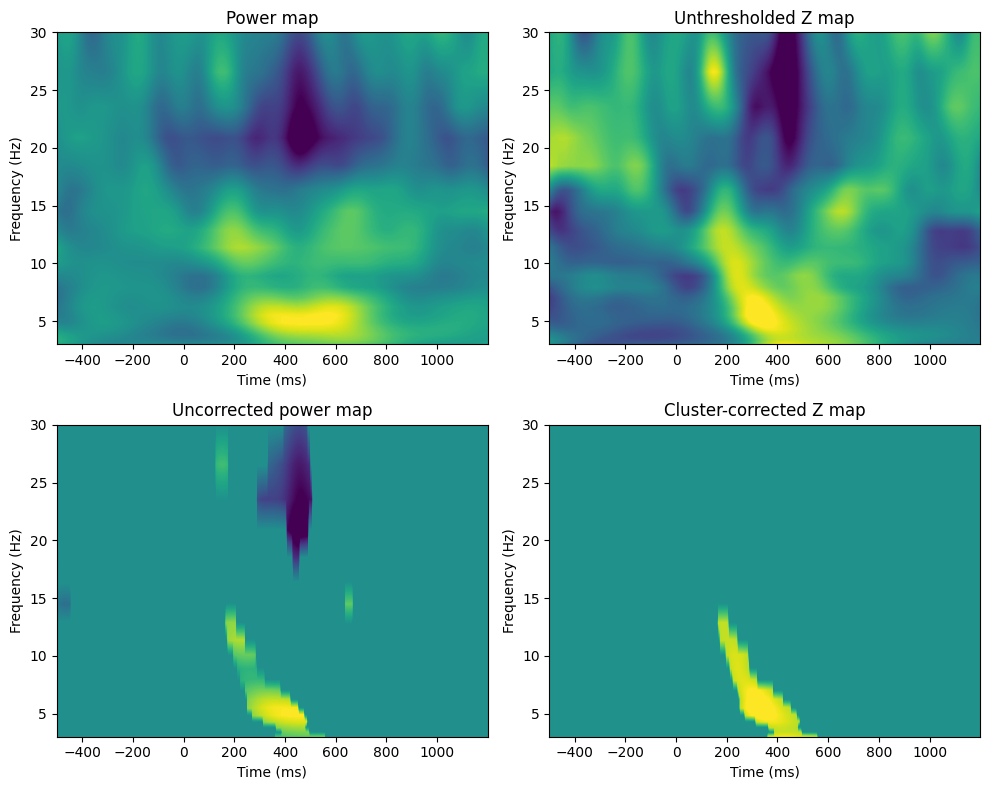

In [ ]:
# Figure 34.1

voxel_pval = 0.01
cluster_pval = 0.05

# Note: try to use 1000 or more permutations for real data
n_permutes = 1000

baseidx = [np.argmin(np.abs(tftimes - t)) for t in [-500, -100]]

# Compute actual t-test of difference
realbaselines = np.mean(eegpower[:, baseidx[0]:baseidx[1]+1, :], axis=1)
realmean = 10 * np.log10(np.mean(eegpower, axis=2) / np.mean(realbaselines, axis=1)[:, None])  # Normalize power

# Initialize null hypothesis matrices
permuted_maxvals = np.zeros((n_permutes, 2, num_frex))
permuted_vals = np.zeros((n_permutes, num_frex, len(tftimes)))
max_clust_info = np.zeros(n_permutes)

# Correcting the cutpoint calculation
for permi in range(n_permutes):
    cutpoint = np.random.choice(range(2, nTimepoints - np.diff(baseidx)[0] - 1))
    permuted_vals[permi, :, :] = 10 * np.log10(np.mean(np.roll(eegpower, cutpoint, axis=1), axis=2) / np.mean(realbaselines, axis=1)[:, None])

zmap = (realmean - np.mean(permuted_vals, axis=0)) / np.std(permuted_vals, axis=0)
threshmean = realmean.copy()
threshmean[np.abs(zmap) < norm.ppf(1 - voxel_pval)] = 0

# Plotting the figures
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Power map
ax = axs[0, 0]
cf = ax.contourf(tftimes, frex, realmean, 40, cmap='viridis', levels=256, vmin=-3, vmax=3)
ax.set_title('Power map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')

# Unthresholded Z map
ax = axs[0, 1]
cf = ax.contourf(tftimes, frex, zmap, 40, cmap='viridis', levels=256, vmin=-3, vmax=3)
ax.set_title('Unthresholded Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')

# Uncorrected power map
ax = axs[1, 0]
cf = ax.contourf(tftimes, frex, threshmean, 40, cmap='viridis', levels=256, vmin=-3, vmax=3)
ax.set_title('Uncorrected power map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')

for permi in range(n_permutes):

    # Cluster correction
    fakecorrsz = (permuted_vals[permi, :, :] - np.mean(permuted_vals, axis=0)) / np.std(permuted_vals, axis=0)
    fakecorrsz[np.abs(fakecorrsz) < norm.ppf(1 - voxel_pval)] = 0

    # Get number of elements in largest supra-threshold cluster
    labeled_array, num_features = label(fakecorrsz)
    max_clust_info[permi] = np.max([0] + [np.sum(labeled_array == i) for i in range(1, num_features + 1)])

# Apply cluster-level corrected threshold
zmapthresh = zmap.copy()
# Uncorrected pixel-level threshold
zmapthresh[np.abs(zmapthresh) < norm.ppf(1 - voxel_pval)] = 0

# Find islands and remove those smaller than cluster size threshold
labeled_array, num_features = label(zmapthresh)
cluster_sizes = np.array([np.sum(labeled_array == i) for i in range(1, num_features + 1)])
clust_threshold = np.percentile(max_clust_info, 100 - cluster_pval * 100)

# Identify clusters to remove
whichclusters2remove = np.where(cluster_sizes < clust_threshold)[0] + 1  # +1 for 1-based indexing

# Remove clusters
for clust in whichclusters2remove:
    zmapthresh[labeled_array == clust] = 0

# Plotting the cluster-corrected Z map
ax = axs[1, 1]
cf = ax.contourf(tftimes, frex, zmapthresh, 40, cmap='viridis', levels=256, vmin=-3, vmax=3)
ax.set_title('Cluster-corrected Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

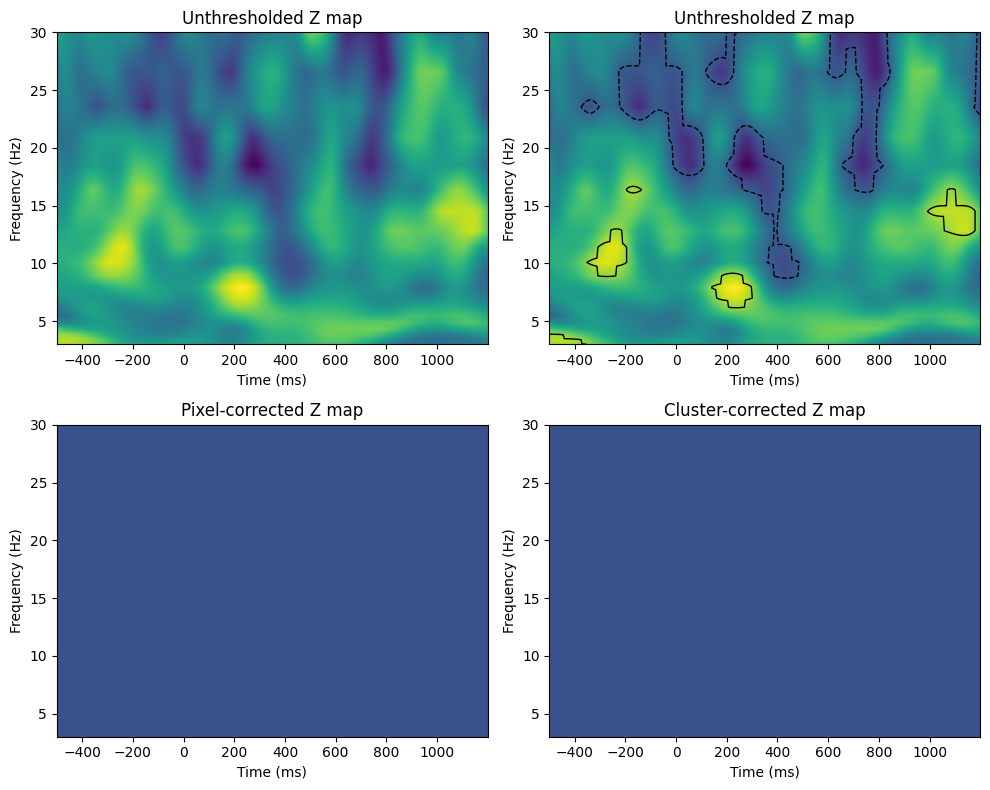

In [ ]:
# Figure 34.3

voxel_pval = 0.05
mcc_voxel_pval = 0.05  # mcc = multiple comparisons correction
mcc_cluster_pval = 0.05

# Note: try to use 1000 or more permutations for real data
n_permutes = 1000

real_condition_mapping = np.concatenate((-np.ones(int(np.floor(EEG['trials'][0, 0] / 2))), np.ones(int(np.ceil(EEG['trials'][0, 0] / 2)))))

# Compute actual t-test of difference (using unequal N and std)
tnum = np.mean(eegpower[:, :, real_condition_mapping == -1], axis=2) - np.mean(eegpower[:, :, real_condition_mapping == 1], axis=2)
tdenom = np.sqrt((np.std(eegpower[:, :, real_condition_mapping == -1], axis=2, ddof=1) ** 2) / np.sum(real_condition_mapping == -1) +
                 (np.std(eegpower[:, :, real_condition_mapping == 1], axis=2, ddof=1) ** 2) / np.sum(real_condition_mapping == 1))
real_t = tnum / tdenom

# Initialize null hypothesis matrices
permuted_tvals = np.zeros((n_permutes, num_frex, nTimepoints))
max_pixel_pvals = np.zeros((n_permutes, 2))
max_clust_info = np.zeros(n_permutes)

# Generate pixel-specific null hypothesis parameter distributions
for permi in range(n_permutes):
    fake_condition_mapping = np.sign(np.random.randn(EEG['trials'][0, 0]))
    
    # Compute t-map of null hypothesis
    tnum = np.mean(eegpower[:, :, fake_condition_mapping == -1], axis=2) - np.mean(eegpower[:, :, fake_condition_mapping == 1], axis=2)
    tdenom = np.sqrt((np.std(eegpower[:, :, fake_condition_mapping == -1], axis=2, ddof=1) ** 2) / np.sum(fake_condition_mapping == -1) +
                     (np.std(eegpower[:, :, fake_condition_mapping == 1], axis=2, ddof=1) ** 2) / np.sum(fake_condition_mapping == 1))
    tmap = tnum / tdenom
    
    # Save all permuted values
    permuted_tvals[permi, :, :] = tmap
    
    # Save maximum pixel values
    max_pixel_pvals[permi, :] = [np.min(tmap), np.max(tmap)]
    
    # For cluster correction, apply uncorrected threshold and get maximum cluster sizes
    tmap[np.abs(tmap) < t.ppf(1 - voxel_pval, EEG['trials'][0, 0] - 1)] = 0
    
    # Get number of elements in largest supra-threshold cluster
    labeled_array, num_features = label(tmap)
    max_clust_info[permi] = np.max([0] + [np.sum(labeled_array == i) for i in range(1, num_features + 1)])

# Now compute Z-map
zmap = (real_t - np.mean(permuted_tvals, axis=0)) / np.std(permuted_tvals, axis=0)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Unthresholded Z map
ax = axs[0, 0]
cf = ax.contourf(tftimes, frex, zmap, 40, cmap='viridis', levels=256)
ax.set_title('Unthresholded Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')

zmapthresh_uncorr = zmap.copy()
t_thresh_uncorr = norm.ppf(1 - voxel_pval)
zmapthresh_uncorr[np.abs(zmapthresh_uncorr) < t_thresh_uncorr] = 0

# Uncorrected thresholded Z map
ax = axs[0, 1]
cf = ax.contourf(tftimes, frex, zmap, 40, cmap='viridis', levels=256)
ax.contour(tftimes, frex, zmapthresh_uncorr, levels=[-t_thresh_uncorr, t_thresh_uncorr], colors='k', linewidths=1)
ax.set_title('Unthresholded Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')

# Apply pixel-level corrected threshold
lower_threshold = np.percentile(max_pixel_pvals[:, 0], mcc_voxel_pval * 100 / 2)
upper_threshold = np.percentile(max_pixel_pvals[:, 1], 100 - mcc_voxel_pval * 100 / 2)

zmapthresh = zmap.copy()
zmapthresh[(zmap > lower_threshold) & (zmap < upper_threshold)] = 0

# Pixel-corrected Z map
ax = axs[1, 0]
cf = ax.contourf(tftimes, frex, zmapthresh, 40, cmap='viridis', levels=256)
ax.set_title('Pixel-corrected Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')

# Apply cluster-level corrected threshold
zmapthresh = zmap.copy()
zmapthresh[np.abs(zmapthresh) < norm.ppf(1 - voxel_pval)] = 0

# Find islands and remove those smaller than cluster size threshold
labeled_array, num_features = label(zmapthresh)
cluster_sizes = np.array([np.sum(labeled_array == i) for i in range(1, num_features + 1)])
clust_threshold = np.percentile(max_clust_info, 100 - mcc_cluster_pval * 100)

# Identify clusters to remove
whichclusters2remove = np.where(cluster_sizes < clust_threshold)[0] + 1  # +1 for 1-based indexing

# Remove clusters
for clust in whichclusters2remove:
    zmapthresh[labeled_array == clust] = 0

# Cluster-corrected Z map
ax = axs[1, 1]
cf = ax.contourf(tftimes, frex, zmapthresh, 40, cmap='viridis', levels=256)
ax.set_title('Cluster-corrected Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

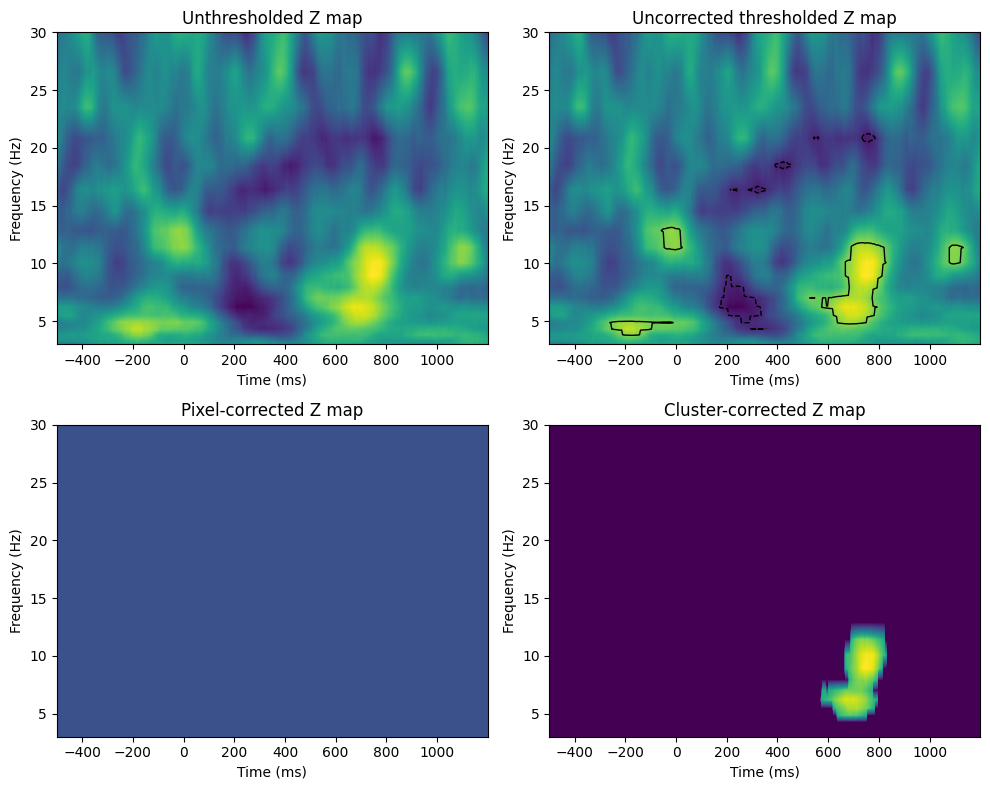

In [ ]:
# Figure 34.4

voxel_pval = 0.01
mcc_voxel_pval = 0.05  # mcc = multiple comparisons correction
mcc_cluster_pval = 0.05

# Note: try to use 1000 or more permutations for real data
n_permutes = 1000

# Define covariates (RT and trial number)
rts = np.zeros(EEG['trials'][0][0])
for ei in range(EEG['trials'][0][0]):
    # In this task, the button press always followed the stimulus at
    # time=0. Thus, finding the RT involves finding the latency of the
    # event that occurs after the time=0 event.
    # If you follow a procedure like this in your data, you may need to
    # include special exceptions, e.g., if there was no response or if
    # a non-response marker could have occurred between stimulus and response.
    time0event = np.where(np.array(EEG['epoch'][0][ei]['eventlatency'][0]) == 0)[0][0]
    rts[ei] = EEG['epoch'][0][ei]['eventlatency'][0][time0event + 1]

# Rank-transform RTs
rtsrank = rankdata(rts)

# Rank-transform power data (must be transformed)
eegpowerreshaped = np.reshape(eegpower, (num_frex * nTimepoints, EEG['trials'][0][0]), 'F').T
eegpowerrank = rankdata(eegpowerreshaped, axis=0).T

# Perform the matrix regression
realcorrs = np.linalg.lstsq((rtsrank.T @ rtsrank)[np.newaxis, np.newaxis], (rtsrank.T @ eegpowerrank.T)[np.newaxis, :], rcond=None)[0]
# Reshape the result to match the dimensions of frequency by time points
realcorrs = np.reshape(realcorrs, (num_frex, nTimepoints), 'F')

# Initialize null hypothesis matrices
permuted_corrs = np.zeros((n_permutes, num_frex, nTimepoints))
max_pixel_pvals = np.zeros((n_permutes, 2))
max_clust_info = np.zeros(n_permutes)

# Generate pixel-specific null hypothesis parameter distributions
for permi in range(n_permutes):
    fake_rt_mapping = rtsrank[np.random.permutation(EEG['trials'][0][0])]

    # Compute t-map of null hypothesis
    fakecorrs = np.linalg.lstsq((fake_rt_mapping.T @ fake_rt_mapping)[np.newaxis, np.newaxis], (fake_rt_mapping.T @ eegpowerrank.T)[np.newaxis, :], rcond=None)[0]

    # Reshape the result to match the dimensions of frequency by time pointsq
    fakecorrs = np.reshape(fakecorrs, (num_frex, nTimepoints), 'F')

    # Save all permuted values
    permuted_corrs[permi, :, :] = fakecorrs

    # Save maximum pixel values
    max_pixel_pvals[permi, :] = [np.min(fakecorrs), np.max(fakecorrs)]

# this time, the cluster correction will be done on the permuted data, thus
# making no assumptions about parameters for p-values
for permi in range(n_permutes):
    
    # Indices of permutations to include in this iteration
    perms2use4distribution = np.ones(n_permutes, dtype=bool)
    perms2use4distribution[permi] = False

    # For cluster correction, apply uncorrected threshold and get maximum cluster sizes
    fakecorrsz = (permuted_corrs[permi, :, :] - np.mean(permuted_corrs[perms2use4distribution, :, :], axis=0)) / np.std(permuted_corrs[perms2use4distribution, :, :], axis=0)
    fakecorrsz[np.abs(fakecorrsz) < norm.ppf(1 - voxel_pval)] = 0

    # Get number of elements in largest supra-threshold cluster
    labeled_array, num_features = label(fakecorrsz)
    max_clust_info[permi] = np.max([0] + [np.sum(labeled_array == i) for i in range(1, num_features + 1)])

# Now compute Z-map
zmap = (realcorrs - np.mean(permuted_corrs, axis=0)) / np.std(permuted_corrs, axis=0)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Unthresholded Z map
ax = axs[0, 0]
cf = ax.contourf(tftimes, frex, zmap, 40, cmap='viridis', levels=256)
ax.set_title('Unthresholded Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')

zmapthresh_uncorr = zmap.copy()
z_thresh_uncorr = norm.ppf(1 - voxel_pval)
zmapthresh_uncorr[np.abs(zmapthresh_uncorr) < z_thresh_uncorr] = 0

# Uncorrected thresholded Z map
ax = axs[0, 1]
cf = ax.contourf(tftimes, frex, zmap, 40, cmap='viridis', levels=256)
ax.contour(tftimes, frex, zmapthresh_uncorr, levels=[-z_thresh_uncorr, z_thresh_uncorr], colors='k', linewidths=1)
ax.set_title('Uncorrected thresholded Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')

# Apply pixel-level corrected threshold
lower_threshold = np.percentile(max_pixel_pvals[:, 0], mcc_voxel_pval * 100 / 2)
upper_threshold = np.percentile(max_pixel_pvals[:, 1], 100 - mcc_voxel_pval * 100 / 2)

zmapthresh = zmap.copy()
zmapthresh[(realcorrs > lower_threshold) & (realcorrs < upper_threshold)] = 0

# Pixel-corrected Z map
ax = axs[1, 0]
cf = ax.contourf(tftimes, frex, zmapthresh, 40, cmap='viridis', levels=256)
ax.set_title('Pixel-corrected Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')

# Apply cluster-level corrected threshold
zmapthresh = zmap.copy()
zmapthresh[np.abs(zmapthresh) < norm.ppf(1 - voxel_pval)] = 0

# Find islands and remove those smaller than cluster size threshold
labeled_array, num_features = label(zmapthresh)
cluster_sizes = np.array([np.sum(labeled_array == i) for i in range(1, num_features + 1)])
clust_threshold = np.percentile(max_clust_info, 100 - mcc_cluster_pval * 100)

# Identify clusters to remove
whichclusters2remove = np.where(cluster_sizes < clust_threshold)[0] + 1  # +1 for 1-based indexing

# Remove clusters
for clust in whichclusters2remove:
    zmapthresh[labeled_array == clust] = 0

# Cluster-corrected Z map
ax = axs[1, 1]
cf = ax.contourf(tftimes, frex, zmapthresh, 40, cmap='viridis', levels=256)
ax.set_title('Cluster-corrected Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

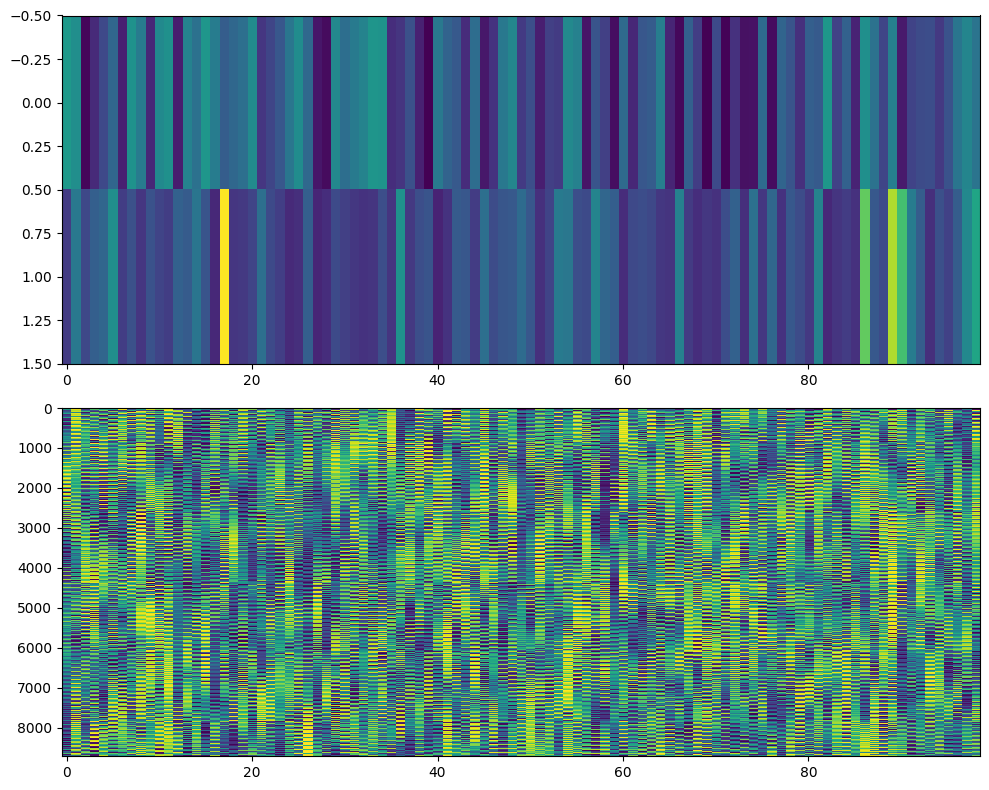

In [ ]:
# Figure 34.5

chan2use = 'O1'
time2use = [np.argmin(np.abs(EEG['times'][0] - t)) for t in [0, 250]]
freq2use = np.argmin(np.abs(frex - 10))

eegfft = fft(EEG['data'][EEG['chanlocs'][0]['labels']==chan2use, :, :].flatten('F'), n_conv_pow2)
eegconv = ifft(wavelets[freq2use, :] * eegfft)
eegconv = eegconv[:n_convolution]
eegconv = eegconv[half_of_wavelet_size: -half_of_wavelet_size]

# Reshape to time X trials
temp = np.abs(np.reshape(eegconv, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')) ** 2
o1power = zscore(np.mean(temp[time2use[0]:time2use[1]+1, :], axis=0))

# Define covariates (RT and trial number)
X = np.vstack((zscore(rtsrank), o1power))
eegpowerrank = rankdata(eegpowerreshaped, axis=0).T

# Plotting the covariate matrix and rank-transformed power data
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Covariate matrix
ax = axs[0]
cax = ax.imshow(X, aspect='auto', cmap='viridis')

# Rank-transformed power data
ax = axs[1]
cax = ax.imshow(eegpowerrank, aspect='auto', cmap='viridis', interpolation='none')

plt.tight_layout()
plt.show()

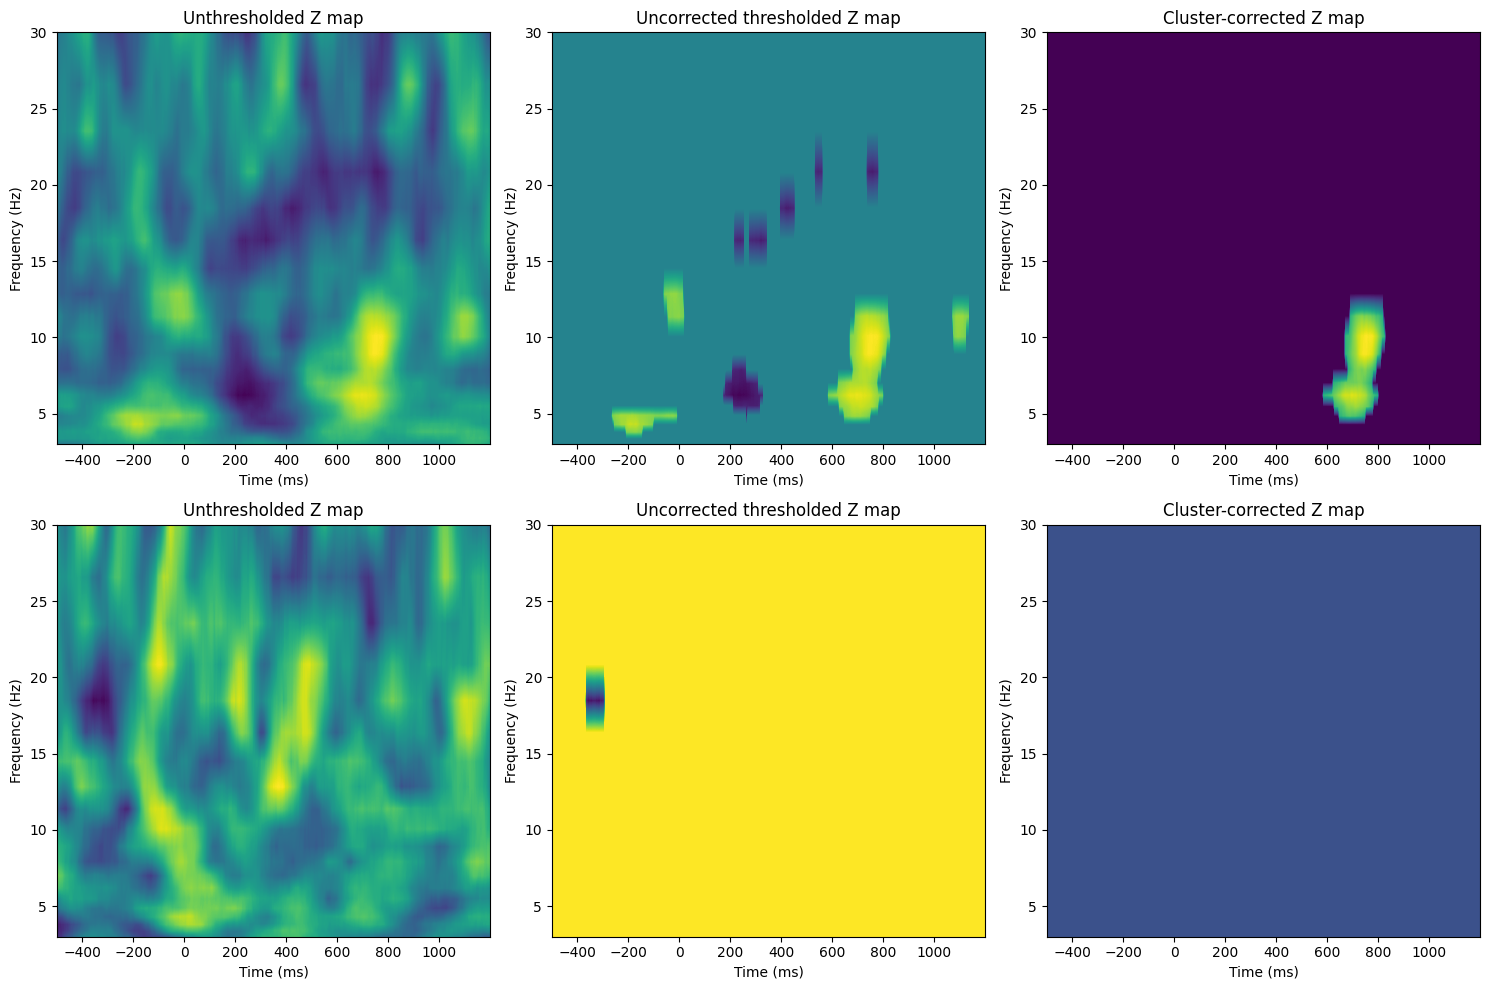

In [ ]:
# Figure 34.6

voxel_pval = 0.01
mcc_cluster_pval = 0.05

# Note: try to use 1000 or more permutations for real data
n_permutes = 1000

# Perform the regression using np.linalg.lstsq
realbeta = np.linalg.lstsq(X @ X.T, X @ eegpowerrank.T, rcond=None)[0]
realbeta = np.reshape(realbeta, (2, num_frex, nTimepoints), order='F')

# Initialize null hypothesis matrices
permuted_bvals = np.zeros((n_permutes, 2, num_frex, nTimepoints))
max_clust_info = np.zeros((n_permutes, 2))

# Generate pixel-specific null hypothesis parameter distributions
for permi in range(n_permutes):
    # Randomly shuffle trial order
    fakeX = X[:, np.random.permutation(EEG['trials'][0][0])]
    
    # Compute beta-map of null hypothesis
    fakebeta = np.linalg.lstsq(fakeX @ fakeX.T, fakeX @ eegpowerrank.T, rcond=None)[0]
    fakebeta = np.reshape(fakebeta, (2, num_frex, nTimepoints), order='F')
    
    # Save all permuted values
    permuted_bvals[permi, :, :, :] = fakebeta

# Cluster correction will be done on the permuted data
for permi in range(n_permutes):
    for testi in range(2):
        # Apply uncorrected threshold and get maximum cluster sizes
        fakecorrsz = (permuted_bvals[permi, testi, :, :] - np.mean(permuted_bvals[:, testi, :, :], axis=0)) / np.std(permuted_bvals[:, testi, :, :], axis=0)
        fakecorrsz[np.abs(fakecorrsz) < norm.ppf(1 - voxel_pval)] = 0
        
        # Get number of elements in largest supra-threshold cluster
        labeled_array, num_features = label(fakecorrsz)
        max_clust_info[permi, testi] = np.max([0] + [np.sum(labeled_array == i) for i in range(1, num_features + 1)])

# Plotting the figures for Figure 34.6
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for testi in range(2):
    
    # Now compute Z-map
    zmap = (realbeta[testi, :, :] - np.mean(permuted_bvals[:, testi, :, :], axis=0)) / np.std(permuted_bvals[:, testi, :, :], axis=0)

    # Unthresholded Z map
    ax = axs[testi, 0]
    cf = ax.contourf(tftimes, frex, zmap, 40, cmap='viridis', levels=256)
    ax.set_title(f'Unthresholded Z map')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')
    
    # Apply uncorrected threshold
    zmapthresh = zmap.copy()
    zmapthresh[np.abs(zmapthresh) < norm.ppf(1 - voxel_pval)] = 0
    
    # Uncorrected thresholded Z map
    ax = axs[testi, 1]
    cf = ax.contourf(tftimes, frex, zmapthresh, 40, cmap='viridis', levels=256)
    ax.set_title(f'Uncorrected thresholded Z map')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')
    
    # Apply cluster-level corrected threshold
    clust_threshold = np.percentile(max_clust_info[:, testi], 100 - mcc_cluster_pval * 100)
    
    # Find islands and remove those smaller than cluster size threshold
    labeled_array, num_features = label(zmapthresh)
    cluster_sizes = np.array([np.sum(labeled_array == i) for i in range(1, num_features + 1)])
    
    # Identify clusters to remove
    whichclusters2remove = np.where(cluster_sizes < clust_threshold)[0] + 1  # +1 for 1-based indexing
    
    # Remove clusters
    for clust in whichclusters2remove:
        zmapthresh[labeled_array == clust] = 0
    
    # Cluster-corrected Z map
    ax = axs[testi, 2]
    cf = ax.contourf(tftimes, frex, zmapthresh, 40, cmap='viridis', levels=256)
    ax.set_title(f'Cluster-corrected Z map')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

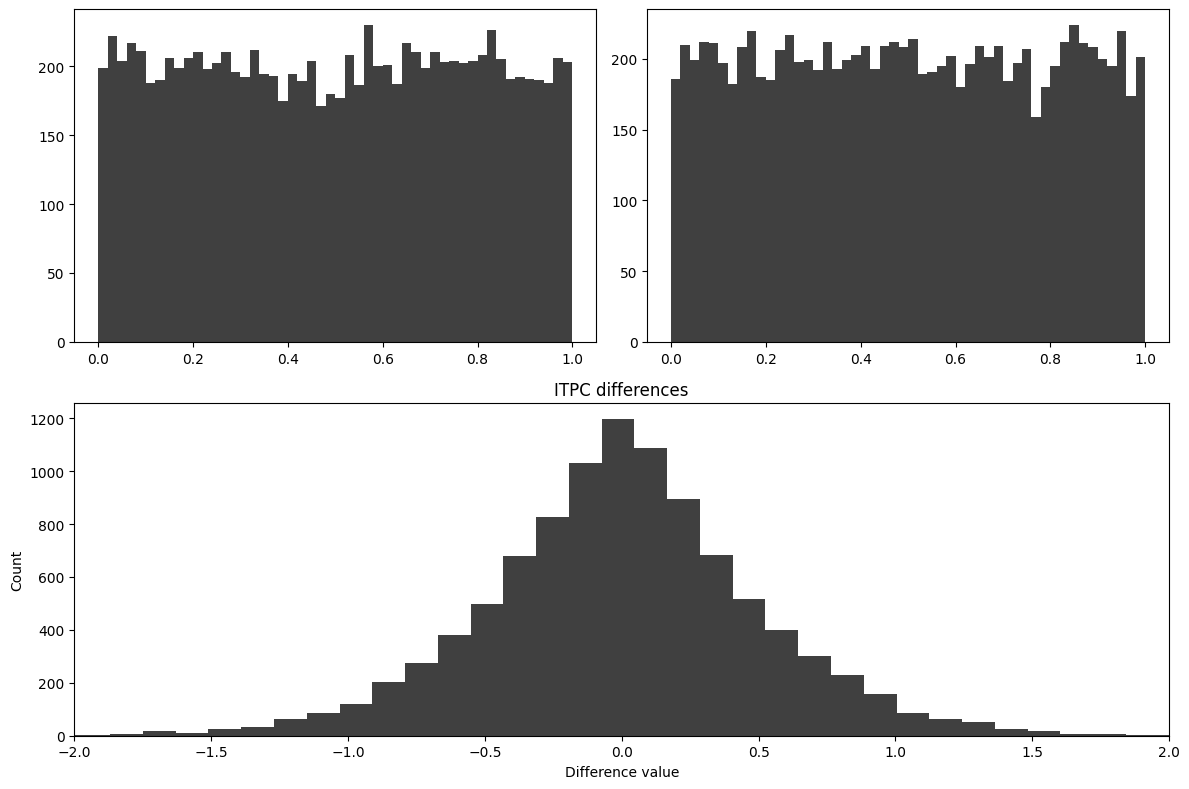

In [ ]:
# Figure 34.7

# Generate random data
a = np.random.rand(10000, 1)
b = np.random.rand(10000, 1)

# Create figure and axes
plt.figure(figsize=(12, 8))

# Histogram of 'a'
ax = plt.subplot(221)
ax.hist(a, bins=50, color='k', alpha=0.75)
ax.set_xlim([-.05, 1.05])

# Histogram of 'b'
ax = plt.subplot(222)
ax.hist(b, bins=50, color='k', alpha=0.75)
ax.set_xlim([-.05, 1.05])

# Histogram of the differences (using Fisher's Z transformation)
ax = plt.subplot(212)
ax.hist(np.arctanh(a - b), bins=50, color='k', alpha=0.75)
ax.set_xlim([-2, 2])
ax.set_title('ITPC differences')
ax.set_xlabel('Difference value')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
# Figure 34.8

# The code to produce this figure is presented in chapter19.m, between the
# cells for figures 19.6 and 19.7. To generate figure 34.8, you will need to run
# the code for figures 19.2-6. 

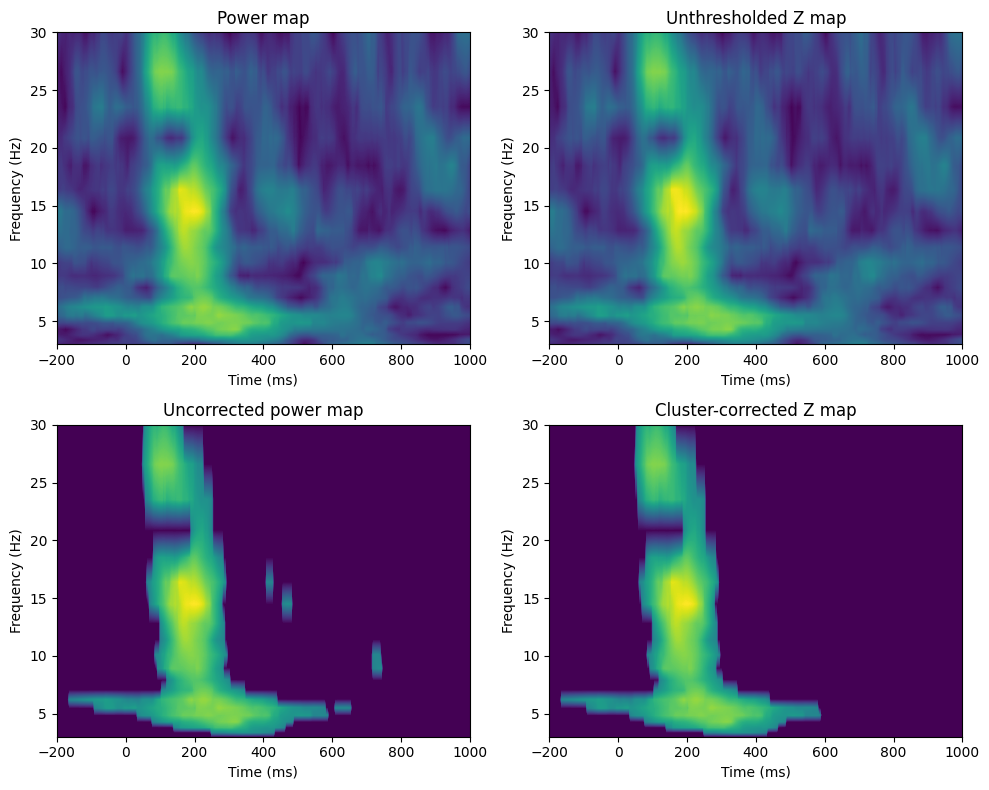

In [ ]:
# Figure 34.9

voxel_pval = 0.01
cluster_pval = 0.05

# Note: try to use 1000 or more permutations for real data
n_permutes = 1000

# Compute actual ITPC
realitpc = np.abs(np.mean(eegphase, axis=2))

# Initialize null hypothesis matrices
permuted_maxvals = np.zeros((n_permutes, 2, num_frex))
permuted_vals = np.zeros((n_permutes, num_frex, EEG['pnts'][0][0]))
max_clust_info = np.zeros(n_permutes)
eegtemp = np.zeros(eegphase.shape, dtype=complex)

for permi in range(n_permutes):
    for triali in range(EEG['trials'][0][0]):
        cutpoint = np.random.choice(range(2, nTimepoints - 1))
        # Permute phase values
        eegtemp[:, :, triali] = np.roll(eegphase[:, :, triali], cutpoint, axis=1)
    permuted_vals[permi, :, :] = np.abs(np.mean(eegtemp, axis=2))

zmap = (realitpc - np.mean(permuted_vals, axis=0)) / np.std(permuted_vals, axis=0)
threshmean = realitpc.copy()
threshmean[np.abs(zmap) < norm.ppf(1 - voxel_pval)] = 0

# Plotting the figures for Figure 34.9
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Power map
ax = axs[0, 0]
cf = ax.contourf(EEG['times'][0], frex, realitpc, 40, cmap='viridis', levels=256)
ax.set_xlim([-200, 1000])
ax.set_title('Power map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')

# Unthresholded Z map
ax = axs[0, 1]
cf = ax.contourf(EEG['times'][0], frex, zmap, 40, cmap='viridis', levels=256)
ax.set_xlim([-200, 1000])
ax.set_title('Unthresholded Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')

# Uncorrected power map
ax = axs[1, 0]
cf = ax.contourf(EEG['times'][0], frex, threshmean, 40, cmap='viridis', levels=256)
ax.set_xlim([-200, 1000])
ax.set_title('Uncorrected power map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')

# this time, the cluster correction will be done on the permuted data, thus
# making no assumptions about parameters for p-values
for permi in range(n_permutes):

    # Cluster correction
    fakecorrsz = (permuted_vals[permi, :, :] - np.mean(permuted_vals, axis=0)) / np.std(permuted_vals, axis=0)
    fakecorrsz[np.abs(fakecorrsz) < norm.ppf(1 - voxel_pval)] = 0

    # Get number of elements in largest supra-threshold cluster
    labeled_array, num_features = label(fakecorrsz)
    max_clust_info[permi] = np.max([0] + [np.sum(labeled_array == i) for i in range(1, num_features + 1)])

# Cluster-corrected Z map
# Apply cluster-level corrected threshold
zmapthresh = realitpc.copy()
zmapthresh[np.abs(zmap) < norm.ppf(1 - voxel_pval)] = 0

# Find islands and remove those smaller than cluster size threshold
labeled_array, num_features = label(zmapthresh)
cluster_sizes = np.array([np.sum(labeled_array == i) for i in range(1, num_features + 1)])
clust_threshold = np.percentile(max_clust_info, 100 - cluster_pval * 100)

# Identify clusters to remove
whichclusters2remove = np.where(cluster_sizes < clust_threshold)[0] + 1  # +1 for 1-based indexing

# Remove clusters
for clust in whichclusters2remove:
    zmapthresh[labeled_array == clust] = 0

ax = axs[1, 1]
cf = ax.contourf(EEG['times'][0], frex, zmapthresh, 40, cmap='viridis', levels=256)
ax.set_xlim([-200, 1000])
ax.set_title('Cluster-corrected Z map')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

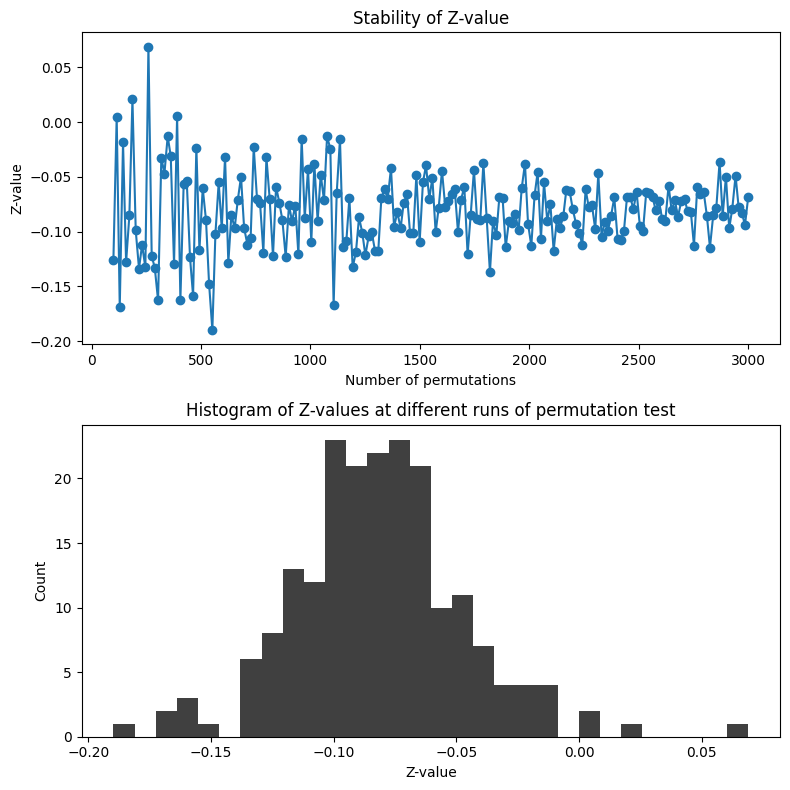

In [ ]:
# Figure 33.5

# The code for figures 33.5/6 are presented here and in the next cell. You
# will need first to run the code for figure 34.3 to run this code.

# Compute actual t-test of difference (using unequal N and std)
tnum = np.mean(eegpower[3, 399, real_condition_mapping == -1]) - np.mean(eegpower[3, 399, real_condition_mapping == 1])
tdenom = np.sqrt((np.std(eegpower[3, 399, real_condition_mapping == -1], ddof=1) ** 2) / np.sum(real_condition_mapping == -1) +
                 (np.std(eegpower[3, 399, real_condition_mapping == 1], ddof=1) ** 2) / np.sum(real_condition_mapping == 1))
real_t = tnum / tdenom

# Set up the range of permutations to test
n_permutes_range = np.round(np.linspace(100, 3000, 200)).astype(int)
zvals = np.zeros(len(n_permutes_range))

# Perform the permutation test for different numbers of permutations
for idx, n_permutes in enumerate(n_permutes_range):
    permuted_tvals = np.zeros(n_permutes)
    
    # Generate null hypothesis parameter distributions
    for permi in range(n_permutes):
        fake_condition_mapping = np.sign(np.random.randn(EEG['trials'][0][0]))
        tnum = np.mean(eegpower[3, 399, fake_condition_mapping == -1]) - np.mean(eegpower[3, 399, fake_condition_mapping == 1])
        tdenom = np.sqrt((np.std(eegpower[3, 399, fake_condition_mapping == -1], ddof=1) ** 2) / np.sum(fake_condition_mapping == -1) +
                         (np.std(eegpower[3, 399, fake_condition_mapping == 1], ddof=1) ** 2) / np.sum(fake_condition_mapping == 1))
        permuted_tvals[permi] = tnum / tdenom
    
    zvals[idx] = (real_t - np.mean(permuted_tvals)) / np.std(permuted_tvals)

# Plot the stability of Z-value as a function of the number of permutations
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot Z-values
ax = axs[0]
ax.plot(n_permutes_range, zvals, marker='o', linestyle='-')
ax.set_xlabel('Number of permutations')
ax.set_ylabel('Z-value')
ax.set_title('Stability of Z-value')

# Histogram of Z-values
ax = axs[1]
ax.hist(zvals, bins=30, color='k', alpha=0.75)
ax.set_xlabel('Z-value')
ax.set_ylabel('Count')
ax.set_title('Histogram of Z-values at different runs of permutation test')

plt.tight_layout()
plt.show()

In [ ]:
tnum / tdenom

array([[ 0.6900473 ,  0.69906177,  0.70821306, ...,  1.51976739,
         1.50579183,  1.48970955],
       [ 1.13221693,  1.14380985,  1.1557384 , ...,  1.39210632,
         1.38067992,  1.36761409],
       [ 1.4598731 ,  1.47179132,  1.48407068, ...,  1.09183971,
         1.10015209,  1.10712079],
       ...,
       [-1.05518666, -1.03844323, -1.00849262, ...,  1.99556023,
         1.88482516,  1.78384207],
       [-1.61870042, -1.59936762, -1.56654329, ...,  1.79811917,
         1.66377941,  1.53064692],
       [-1.43522339, -1.44002911, -1.43904482, ...,  0.08468227,
         0.09266911,  0.08359325]])

In [ ]:
real_t

array([[ 1.92409318,  1.93799449,  1.95104155, ..., -0.88392747,
        -0.88830475, -0.89335801],
       [ 2.08568485,  2.09873798,  2.11051953, ..., -0.7674469 ,
        -0.75174094, -0.73673116],
       [ 1.87780796,  1.87858681,  1.87730406, ..., -0.29878025,
        -0.28154403, -0.26507296],
       ...,
       [-1.16226796, -1.09787529, -1.03706577, ..., -1.98438195,
        -2.05500952, -2.11943243],
       [-1.02458395, -0.91130896, -0.81098154, ..., -1.61005073,
        -1.60534137, -1.59837314],
       [-0.05420381, -0.04360291, -0.04128698, ..., -1.76290619,
        -1.82481761, -1.88206451]])

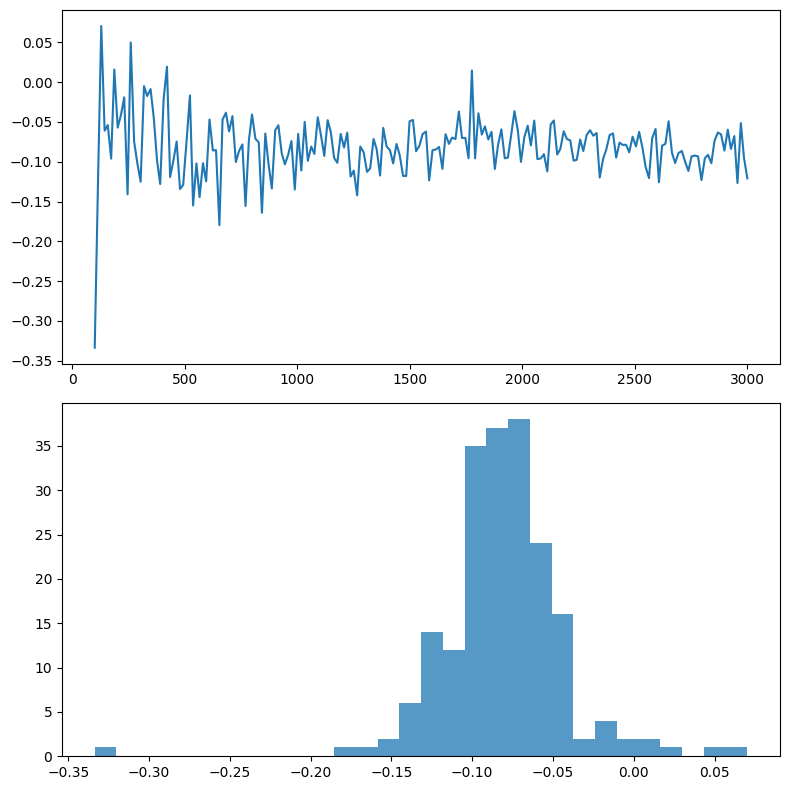

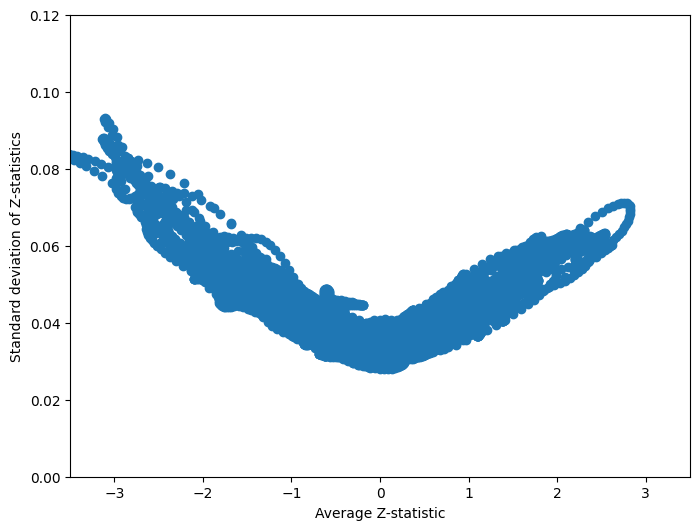

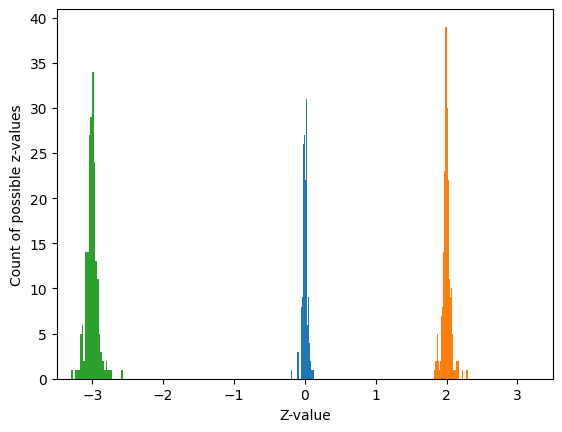

In [ ]:
# Figure 33.6

# Compute actual t-test of difference (using unequal N and std)
tnum = np.mean(eegpower[:, :, real_condition_mapping == -1], axis=2) - np.mean(eegpower[:, :, real_condition_mapping == 1], axis=2)
tdenom = np.sqrt((np.std(eegpower[:, :, real_condition_mapping == -1], axis=2, ddof=1) ** 2) / np.sum(real_condition_mapping == -1) +
                 (np.std(eegpower[:, :, real_condition_mapping == 1], axis=2, ddof=1) ** 2) / np.sum(real_condition_mapping == 1))
real_t = tnum / tdenom

# Set up the range of permutations to test
n_permutes_range = np.round(np.linspace(100, 3000, 200)).astype(int)
zvals = np.zeros((len(n_permutes_range), tnum.shape[0], tnum.shape[1]))

# Perform the permutation test for different numbers of permutations
for grandpermi, n_permutes in enumerate(n_permutes_range):
    permuted_tvals = np.zeros((n_permutes, tnum.shape[0], tnum.shape[1]))
    
    # Generate null hypothesis parameter distributions
    for permi in range(n_permutes):
        fake_condition_mapping = np.sign(np.random.randn(EEG['trials'][0][0]))
        tnum = np.mean(eegpower[:, :, fake_condition_mapping == -1], axis=2) - np.mean(eegpower[:, :, fake_condition_mapping == 1], axis=2)
        tdenom = np.sqrt((np.std(eegpower[:, :, fake_condition_mapping == -1], axis=2, ddof=1) ** 2) / np.sum(fake_condition_mapping == -1) +
                         (np.std(eegpower[:, :, fake_condition_mapping == 1], axis=2, ddof=1) ** 2) / np.sum(fake_condition_mapping == 1))
        permuted_tvals[permi, :, :] = tnum / tdenom
    
    zvals[grandpermi, :, :] = (real_t - np.mean(permuted_tvals, axis=0)) / np.std(permuted_tvals, axis=0)

# Plot the stability of Z-value as a function of the number of permutations for the selected time-frequency point
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot Z-values for the selected time-frequency point
ax = axs[0]
ax.plot(n_permutes_range, zvals[:, 3, 399], linestyle='-')

# Histogram of Z-values for the selected time-frequency point
ax = axs[1]
ax.hist(zvals[:, 3, 399], bins=30, alpha=0.75)

plt.tight_layout()
plt.show()

# Plot the average and standard deviation of Z-statistics across all time-frequency points
zvals_all = zvals.reshape(len(n_permutes_range), num_frex * nTimepoints)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.mean(zvals_all, axis=0), np.std(zvals_all, axis=0), 'o')
ax.set_xlim([-3.5, 3.5])
ax.set_ylim([0, 0.12])
ax.set_xlabel('Average Z-statistic')
ax.set_ylabel('Standard deviation of Z-statistics')
plt.show()

plt.figure()

z0 = np.argmin(np.abs(np.mean(zvals_all, axis=0)))
x0, y0 = np.unravel_index(z0, tnum.shape)
yy, xx = np.histogram(zvals[:, x0, y0], bins=30)
width = np.diff(xx)  # Calculate the width of each bin
center = (xx[:-1] + xx[1:]) / 2  # Calculate the center of each bin
h = plt.bar(center, yy, width=width, align='center')

z2 = np.argmin(np.abs(np.mean(zvals_all, axis=0)-2))
x2, y2 = np.unravel_index(z2, tnum.shape)
yy, xx = np.histogram(zvals[:, x2, y2], bins=30)
width = np.diff(xx)  # Calculate the width of each bin
center = (xx[:-1] + xx[1:]) / 2  # Calculate the center of each bin
h = plt.bar(center, yy, width=width, align='center')

z3 = np.argmin(np.abs(np.mean(zvals_all, axis=0)+3))
x3, y3 = np.unravel_index(z3, tnum.shape)
yy, xx = np.histogram(zvals[:, x3, y3], bins=30)
width = np.diff(xx)  # Calculate the width of each bin
center = (xx[:-1] + xx[1:]) / 2  # Calculate the center of each bin
h = plt.bar(center, yy, width=width, align='center')

plt.xlim([-3.5, 3.5])
plt.xlabel('Z-value')
plt.ylabel('Count of possible z-values')

plt.show()